Total Ejecta Mass Mean: 22.103487897397297
Total Ejecta Mass Uncertainty: 30.656392564266152
Maximum Total Ejecta Mass: 278.1401081105046
M1 for Maximum Total Ejecta Mass: 1.9919431340181957
M2 for Maximum Total Ejecta Mass: 1.1002976844173464
r_merger for Maximum Total Ejecta Mass: 2026.1961324363592
815000
1630000


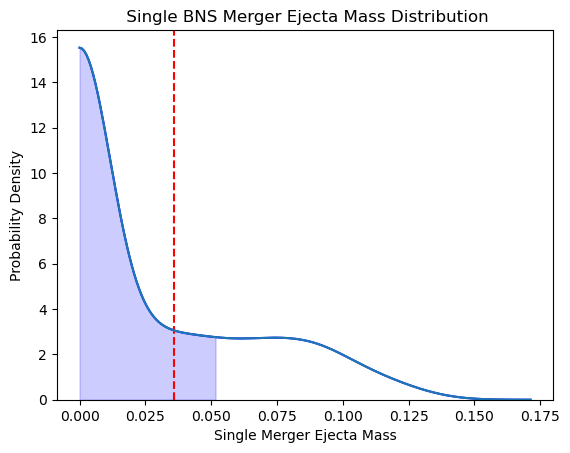

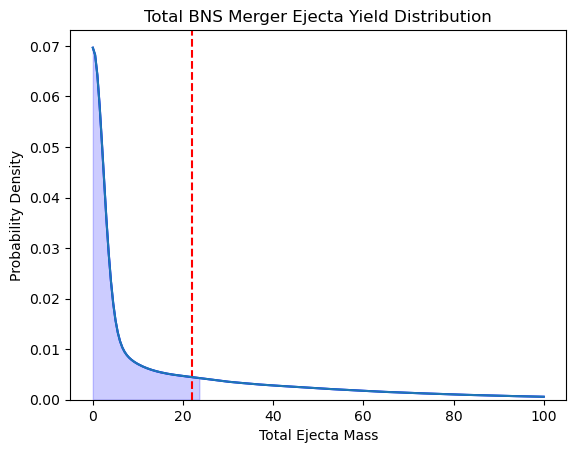

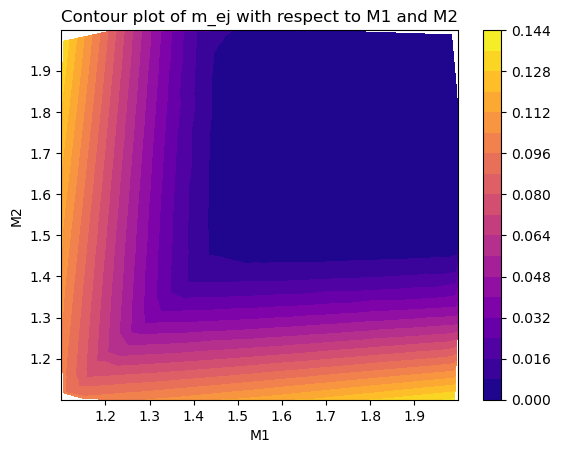

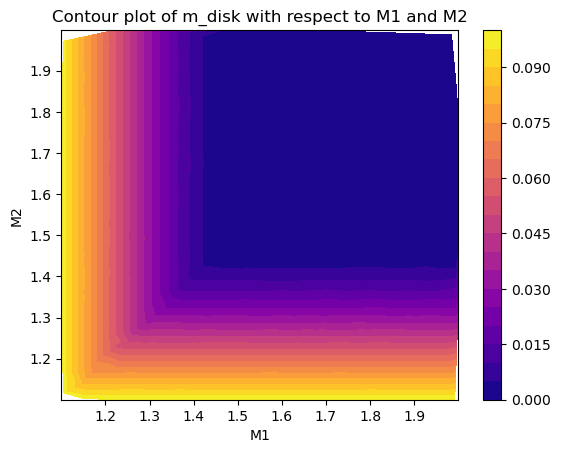

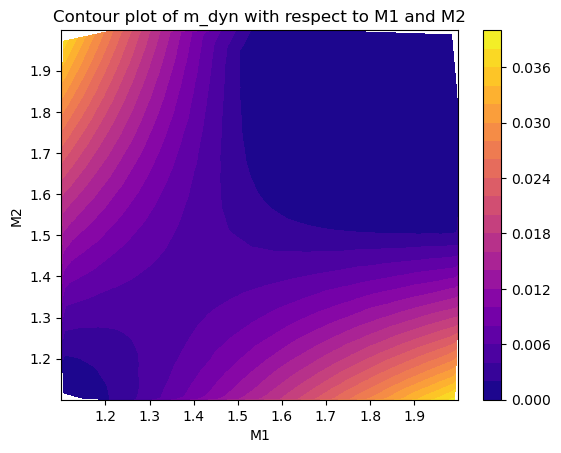

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 24 15:22:41 2023

@author: neilcao
"""

import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constants(?)
G = 6.6743e-20 # km^3 kg^-1 s^-2, gravitational constant
c = 299792.458 # km s^-1, speed of light
M_sun = 1.989e30 # kg, mass of the sun


# Fitted coefficients
a=-8.1324
b=1.4820
d=1.7784

e=-9.3335
f=114.17
g=-337.56
n=1.5465


# Input parameters
R1 = 12 # km, radius of primary component
R2 = 12 # km, radius of secondary component
alpha_dyn = 1 # Coefficient of uncertainty
f_loss = 0.5 # Fraction of disk mass ejected

def calc_compactness(M, R, G, c):
    C = G * M * M_sun / (R * c**2)
    return C


def calc_disk_mass(M1, M2, R1, R2, G, c, a, b, d):
    if M1 < M2:
        M_min = M1
        C_min = calc_compactness(M1, R1, G, c)
    else:
        M_min = M2
        C_min = calc_compactness(M2, R2, G, c)
            
            
    if a * C_min + b < 0:
        m_disk = M_min * 5e-4
    else:
        m_disk = M_min * max(5e-4, (a * C_min + b)**d)

    return m_disk


def calc_dynamical_mass(M1, M2, R1, R2, G, c, e, f, g, n):
    C1 = calc_compactness(M1, R1, G, c)
    C2 = calc_compactness(M2, R2, G, c)

    m_dyn = ((e / C1 + f * (M2**n) / (M1**n) + g * C1) * M1 + (e / C2 + f * (M1**n) / (M2**n) + g * C2) * M2) * 1e-3
    if m_dyn < 0:
        m_dyn = 0
    return m_dyn


def calc_single_merger_ejecta(M1, M2, R1, R2, G, c, alpha_dyn, f_loss):
    m_disk = calc_disk_mass(M1, M2, R1, R2, G, c, a, b, d)
    m_dyn = calc_dynamical_mass(M1, M2, R1, R2, G, c, e, f, g, n)

    m_ej = alpha_dyn * m_dyn + f_loss * m_disk
    
    return m_ej


def calc_total_ejecta(M1, M2, R1, R2, G, c, alpha_dyn, f_loss, r_merger):
    m_ej = calc_single_merger_ejecta(M1, M2, R1, R2, G, c, alpha_dyn, f_loss)

    m_total = m_ej * r_merger
    return m_total


a1, b1 = 1.1, 2.0
N = 1000
mu1, sigma1 = 440, 500


samples1 = np.random.normal(mu1, sigma1, N)

def sample_top_hat(a1, b1, N):
    samples = [random.uniform(a1, b1) for _ in range(N)]
    return samples


samples2 = sample_top_hat(a1, b1, N)
samples3 = sample_top_hat(a1, b1, N)

accepted_single_ejecta_samples = []
accepted_total_ejecta_samples = []
accepted_disk_mass_samples = []
accepted_dynamical_ejecta_sampels = []


for M1, M2 in zip(samples2, samples3):
    m_disk = calc_disk_mass(M1, M2, R1, R2, G, c, a, b, d)
    m_dyn = calc_dynamical_mass(M1, M2, R1, R2, G, c, e, f, g, n)
    m_ej = calc_single_merger_ejecta(M1, M2, R1, R2, G, c, alpha_dyn, f_loss)
    accepted_single_ejecta_samples.append(m_ej)
    accepted_disk_mass_samples.append(m_disk)
    accepted_dynamical_ejecta_sampels.append(m_dyn)


max_m_total = 0
max_M1 = 0
max_M2 = 0
max_r_merger = 0
accepted_total_ejecta_samples = []


samples1_array = np.array(samples1)
samples2_array = np.array(samples2)
samples3_array = np.array(samples3)
accepted_single_ejecta_samples_array = np.array(accepted_single_ejecta_samples)


m_total_matrix = samples1_array[:, None] * accepted_single_ejecta_samples_array


accepted_total_ejecta_samples_filtered = m_total_matrix[m_total_matrix > 0]
accepted_total_ejecta_samples = accepted_total_ejecta_samples_filtered.tolist()


max_m_total_index = np.unravel_index(np.argmax(m_total_matrix, axis=None), m_total_matrix.shape)
max_m_total = m_total_matrix[max_m_total_index]
max_r_merger = samples1_array[max_m_total_index[0]]
max_M1 = samples2_array[max_m_total_index[1]]
max_M2 = samples3_array[max_m_total_index[1]]



reflected_total_ejecta_samples = [-1 * x for x in accepted_total_ejecta_samples]
reflected_single_ejecta_samples = [-1 * x for x in accepted_single_ejecta_samples]

combined_samples_total = np.concatenate((accepted_total_ejecta_samples, reflected_total_ejecta_samples))
combined_samples_single = np.concatenate((accepted_single_ejecta_samples, reflected_single_ejecta_samples))



C1 = calc_compactness(M1, R1, G, c)
C2 = calc_compactness(M2, R2, G, c)
m_disk = calc_disk_mass(M1, M2, R1, R2, G, c, a, b, d)
m_dyn = calc_dynamical_mass(M1, M2, R1, R2, G, c, e, f, g, n)
m_ej = calc_single_merger_ejecta(M1, M2, R1, R2, G, c, alpha_dyn, f_loss)



# Outputs
print("Total Ejecta Mass Mean:", np.mean(accepted_total_ejecta_samples))
print("Total Ejecta Mass Uncertainty:", np.std(accepted_total_ejecta_samples))

print("Maximum Total Ejecta Mass:", max_m_total)
print("M1 for Maximum Total Ejecta Mass:", max_M1)
print("M2 for Maximum Total Ejecta Mass:", max_M2)
print("r_merger for Maximum Total Ejecta Mass:", max_r_merger)

print(len(accepted_total_ejecta_samples))
print(len(combined_samples_total))


# KDE density plots, confidence intervals
single_lower = np.percentile(combined_samples_single, (100 - 68) / 2)
single_upper = np.percentile(combined_samples_single, 100 - (100 - 68) / 2)

sns.kdeplot(combined_samples_single, color = 'blue', clip = (0, 5))
plt.axvline(np.mean(accepted_single_ejecta_samples), linestyle='--', color = 'red')

single_kde = sns.kdeplot(combined_samples_single, clip=(0, 5)).get_lines()[0].get_data()
single_x = single_kde[0]
single_y = single_kde[1]
single_x_conf = np.where((single_x >= single_lower) & (single_x <= single_upper))
plt.fill_between(single_x[single_x_conf], single_y[single_x_conf], color='blue', alpha=0.2, label='68% CI')
plt.xlabel('Single Merger Ejecta Mass')
plt.ylabel('Probability Density')
plt.title(' Single BNS Merger Ejecta Mass Distribution')
plt.show()


total_lower = np.percentile(combined_samples_total, (100 - 68) / 2)
total_upper = np.percentile(combined_samples_total, 100 - (100 - 68) / 2)

sns.kdeplot(combined_samples_total, color = 'blue', clip = (0, 100))
plt.axvline(np.mean(accepted_total_ejecta_samples), linestyle='--', color = 'red')

total_kde = sns.kdeplot(combined_samples_total, clip=(0, 100)).get_lines()[0].get_data()
total_x = total_kde[0]
total_y = total_kde[1]
total_x_conf = np.where((total_x >= total_lower) & (total_x <= total_upper))
plt.fill_between(total_x[total_x_conf], total_y[total_x_conf], color='blue', alpha=0.2, label='68% CI')
plt.xlabel('Total Ejecta Mass')
plt.ylabel('Probability Density')
plt.title('Total BNS Merger Ejecta Yield Distribution')
plt.show()



# Contour plot for m_ej
df = pd.DataFrame(columns=["M1", "M2", "m_ej"])

for M1, M2 in zip(samples2, samples3):
    m_ej = calc_single_merger_ejecta(M1, M2, R1, R2, G, c, alpha_dyn, f_loss)
    if m_ej > 0:
        df = pd.concat([df, pd.DataFrame.from_records([{ "M1": M1, "M2": M2, "m_ej": m_ej }])])

plt.tricontourf(df["M1"], df["M2"], df["m_ej"], levels=20, cmap='plasma')
plt.colorbar()

plt.xlabel('M1')
plt.ylabel('M2')
plt.title('Contour plot of m_ej with respect to M1 and M2')
plt.show()



# Contour plot for m_disk
df = pd.DataFrame(columns=["M1", "M2", "m_disk"])

for M1, M2 in zip(samples2, samples3):
    m_disk = f_loss * calc_disk_mass(M1, M2, R1, R2, G, c, a, b, d)
    if m_disk > 0:
        df = pd.concat([df, pd.DataFrame.from_records([{ "M1": M1, "M2": M2, "m_disk": m_disk }])])

plt.tricontourf(df["M1"], df["M2"], df["m_disk"], levels=20, cmap='plasma')
plt.colorbar()

plt.xlabel('M1')
plt.ylabel('M2')
plt.title('Contour plot of m_disk with respect to M1 and M2')
plt.show()



# Contour plot for m_dyn
df = pd.DataFrame(columns=["M1", "M2", "m_dyn"])

for M1, M2 in zip(samples2, samples3):
    m_dyn = calc_dynamical_mass(M1, M2, R1, R2, G, c, e, f, g, n)
    df = pd.concat([df, pd.DataFrame.from_records([{ "M1": M1, "M2": M2, "m_dyn": m_dyn }])])

plt.tricontourf(df["M1"], df["M2"], df["m_dyn"], levels=20, cmap='plasma')
plt.colorbar()

plt.xlabel('M1')
plt.ylabel('M2')
plt.title('Contour plot of m_dyn with respect to M1 and M2')
plt.show()